In [78]:
import pandas as pd
import numpy as np
import sklearn
from PIL.GimpGradientFile import linear
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [79]:
data = pd.read_csv("GOOGL.csv", parse_dates=True, index_col=0).dropna()
data.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2024-01-22,145.462692,0.0,147.854017,145.313225,146.568684,0.0,32200400.0
2024-01-23,146.508896,0.0,146.648390,144.974465,145.363056,0.0,21636100.0
2024-01-24,148.162903,0.0,149.308758,147.565079,148.003477,0.0,25233500.0
2024-01-25,151.321442,0.0,152.497187,148.999856,149.527955,0.0,29149100.0
2024-01-26,151.640289,0.0,151.989016,150.464544,150.554230,0.0,26115500.0


In [80]:
data[data['Stock Splits'] > 0]

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,


No Stock Splits.

In [81]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    """
    Generate lagged features for a specified column
    """
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

In [82]:
def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

In [83]:
def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Avg_Price'] = (df['Close'] + df['Open']) / 2
    df['Returns'] = np.log(df['Avg_Price'] / df['Avg_Price'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    df = df.dropna()
    df = scale_columns(df, 10)
    return df


In [84]:
def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    return train_test_split(df[feature_cols], df[['Target', 'Target_Returns']], test_size=0.3, shuffle=False)


In [85]:
global models
supervised_models = {
    'mlp': sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 70, 50), activation='logistic', max_iter=2000),
    'dt': sklearn.tree.DecisionTreeClassifier(max_depth=5),
    'svm_ln': SVC(kernel='linear'),
    'svm_rbf': SVC(kernel='rbf'),
    'lnr': LinearRegression(),
    'lgr': LogisticRegression(),
    'nb_gs': GaussianNB(),
    'nb_bnl': BernoulliNB()
}

def fit_and_predict_supervised_models(X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if not save_to else save_to
    for model_name, model in supervised_models.items():
        model.fit(X_train, y_train['Target'])
        y_test[f'pos_{model_name}'] = model.predict(X_test)
        y_test[f'pos_{model_name}'] = np.sign(y_test[f'pos_{model_name}'])
        y_test[f'pos_{model_name}'] = np.where(y_test[f'pos_{model_name}'] < -0.5, -0.5, y_test[f'pos_{model_name}'])
        df_result[f'ret_{model_name}'] = y_test[f'pos_{model_name}'] * y_test['Target_Returns']
        df_result[f'cum_ret_{model_name}'] = df_result[f'ret_{model_name}'].cumsum()

    df_result['ret_benchmark'] = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = df_result['ret_benchmark'].cumsum()

    for col in df_result.columns:
        if col[:3] != 'cum':
            df_result = df_result.drop(columns=[col])

    return df_result


In [86]:
unsupervised_models = {
    'kmean': KMeans(n_clusters=2),
    'gsmixture': GaussianMixture(n_components=2)
}

def fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if save_to is None else save_to.copy()

    for model_name, model in unsupervised_models.items():
        # Fit the model on training data
        model.fit(X_train)
        predictions = model.predict(X_test)
        signal = np.sign(predictions)
        signal = np.where(signal < -0.5, -0.5, signal)

        ret_original = signal * y_test['Target_Returns']
        cum_ret_original = ret_original.cumsum()

        flipped_signal = -signal
        ret_flipped = flipped_signal * y_test['Target_Returns']
        cum_ret_flipped = ret_flipped.cumsum()

        # Select the alignment with the higher final cumulative return
        if cum_ret_flipped.iloc[-1] > cum_ret_original.iloc[-1]:
            chosen_cum_ret = cum_ret_flipped
        else:
            chosen_cum_ret = cum_ret_original

        # Store the chosen cumulative returns for the model
        df_result[f'cum_ret_{model_name}'] = chosen_cum_ret

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = benchmark_ret.cumsum()

    # Remove any non-cumulative columns
    for col in list(df_result.columns):
        if not col.startswith('cum'):
            df_result.drop(columns=[col], inplace=True)

    return df_result


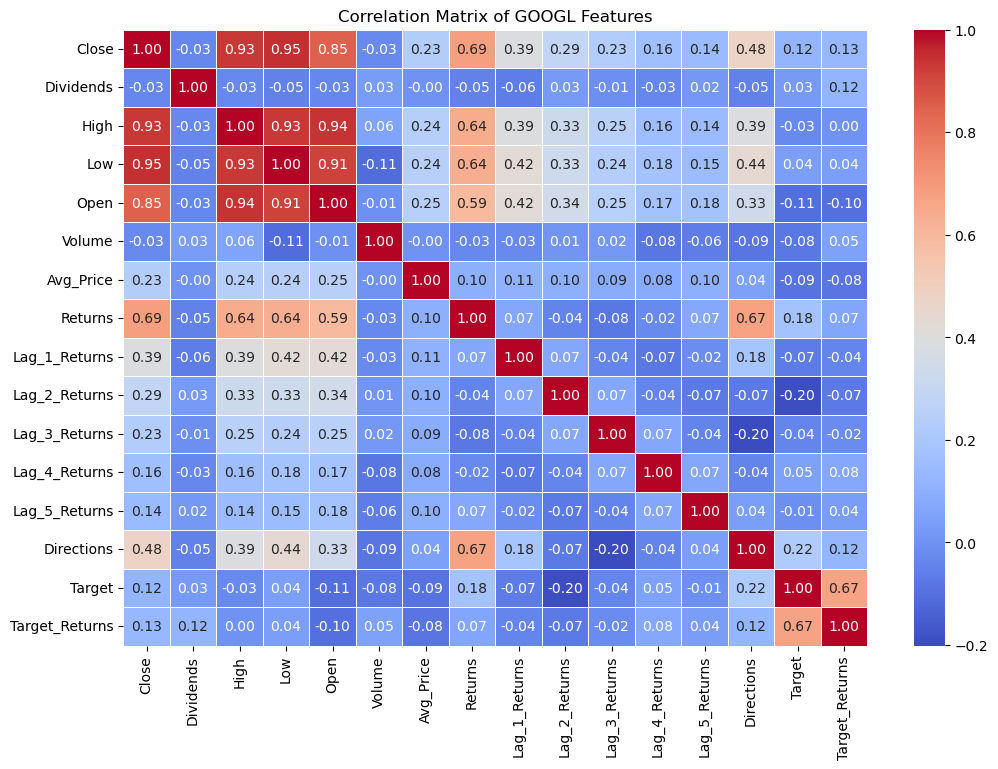

In [87]:
data = pd.read_csv("GOOGL.csv", parse_dates=True, index_col=0).dropna()
data = preprocess_data(data)
data = data.drop(columns=['Stock Splits'])

corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of GOOGL Features")
plt.show()

In [88]:

X_train, X_test, y_train, y_test = stock_train_test_split(data)
df_result = fit_and_predict_supervised_models(X_train, X_test, y_train, y_test)
df_result = fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=df_result)

Text(0.5, 1.0, 'Cumulative Log Returns for GOOGL')

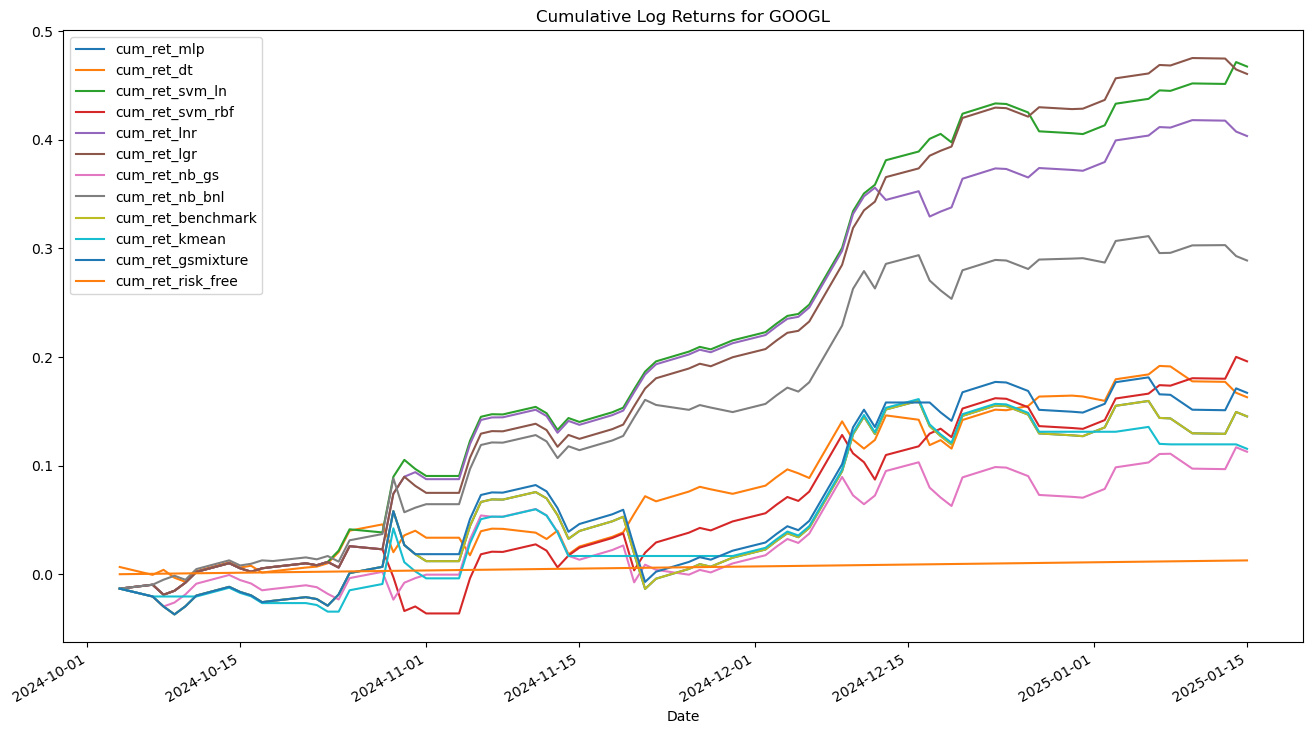

In [89]:
risk_free_rate = 0.045 / 365
days_elapsed = (df_result.index - df_result.index[0]).days
df_result['cum_ret_risk_free'] = risk_free_rate * days_elapsed

ax = df_result.plot(figsize=(16,9))
ax.set_title('Cumulative Log Returns for GOOGL')